# Gender Prediction on CelebA

## Import Libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping
import seaborn as sns
from sklearn.metrics import accuracy_score,classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn import svm
import glob
import h5py
import cv2
from ipywidgets import interact
import ipywidgets as widgets

## Define constants

In [2]:
num_epochs = 1
batch_size = 32
train_size = 162770
filelist = glob.glob("../../../CO352/FaceGAN/Data/img_align_celeba/*.jpg")

## Load Data

In [21]:
def get_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if(img.shape[0]!=img.shape[1]):
        img = img[20:198,:]
    img = cv2.resize(img,(64,64))
    img = ((img.astype(float).reshape(64,64,1))/255)
    return img

In [4]:
def get_batches(batch_size,start_index=0,end_index=train_size):
    for i in range(start_index,end_index,batch_size):
        X = []
        for j in range(i,min(end_index,i+batch_size)):
            X.append(get_image(filelist[j]))
        X = np.array(X)
        y = (label_df["Male"][i:min(end_index,i+batch_size)]==1).astype(int).values
        yield X,y

In [5]:
label_df = pd.read_csv("../Data/list_attr_celeba.txt",sep='\s+')
label_df.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


## VGG-16 Model

In [6]:
model = Sequential()
model.add(Convolution2D(32,(3,3),activation='relu',input_shape=(64,64,1),padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Convolution2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Convolution2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(128,(3,3),activation='relu',padding='same'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.load_weights("../Models/CelebA_GRAYSCALE_64/Gender/model-001-5087.hdf5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 64)        256       
__________

## Training the Model

In [7]:
for epoch_i in range(num_epochs):
    loss_avg = 0.0
    acc_avg = 0.0
    step = 5000
    laststep = 5000
    for X,y in get_batches(batch_size,5000*batch_size):
        loss,acc = model.train_on_batch(X,y)
        loss_avg+=loss
        acc_avg+=acc
        step+=1
        diffstep = step-laststep
        if(diffstep%1000)==0:
            print("Epoch {}\tStep {}\tLoss {:.4f}\tAccuracy {:.4f}".format(epoch_i+1,step,loss_avg/diffstep,acc_avg/diffstep))
            model.save("../Models/CelebA_GRAYSCALE_64/Gender/model-{:03d}-{:04d}.hdf5".format(epoch_i+1,step))
            acc_avg = 0.0
            loss_avg = 0.0
            laststep = step
    print("Epoch {}\tStep {}\tLoss {:.4f}\tAccuracy {:.4f}".format(epoch_i+1,step,loss_avg/diffstep,acc_avg/diffstep))
    model.save("../Models/CelebA_GRAYSCALE_64/Gender/model-{:03d}-{:04d}.hdf5".format(epoch_i+1,step))

Epoch 1	Step 5087	Loss 0.1400	Accuracy 0.9506


## Results

In [13]:
y_true = np.array([])
y_pred = np.array([])
step = 0
for X,y in get_batches(batch_size,train_size,len(label_df)):
    y_true = np.append(y_true,y)
    y_pred = np.append(y_pred,model.predict(X))
    step+=1
    if(step%100)==0:
        print("Step {}".format(step))

Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Step 1100
Step 1200


In [17]:
y_pred_int = np.array([0 if i < 0.5 else 1 for i in y_pred])
print(classification_report(y_true,y_pred_int,target_names=["Female","Male"]))

             precision    recall  f1-score   support

     Female       0.96      0.98      0.97     23656
       Male       0.97      0.94      0.96     16173

avg / total       0.96      0.96      0.96     39829



In [7]:
def check_and_eval(image_number):
    X = cv2.imread(filelist[image_number-1])
    X = cv2.cvtColor(X,cv2.COLOR_BGR2RGB)
    plt.imshow(X)
    plt.show()
    X = get_image(filelist[image_number-1]).reshape(-1,64,64,1)
    y_pred = model.predict(X)
    y_true = (label_df["Male"][image_number-1]+1)//2
    if(y_true==1):
        print("Label is Male")
    else:
        print("Label is Female")
    print("Male Probability: {:.4f}\tFemale Probability: {:.4f}".format((y_pred[0][0])*100.0,(1-y_pred[0][0])*100.0))
    if(y_pred<0.5):
        print("Prediction: Female")
    else:
        print("Prediction: Male")

In [19]:
interact(check_and_eval, image_number=widgets.IntSlider(min=1,max=len(label_df),value=100))

<function __main__.check_and_eval>

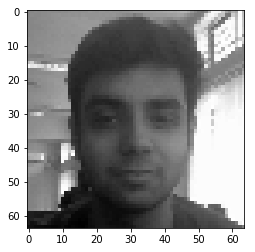

In [26]:
mehul = get_image("../Data/MehulMale.jpg").reshape(64,64)
plt.imshow(mehul,cmap='gray')
plt.show()

In [28]:
y_pred = model.predict(mehul.reshape(-1,64,64,1))
print("Male Probability: {:.4f}\tFemale Probability: {:.4f}".format((y_pred[0][0])*100.0,(1-y_pred[0][0])*100.0))
if(y_pred<0.5):
    print("Prediction: Female")
else:
    print("Prediction: Male")

Male Probability: 96.7324	Female Probability: 3.2676
Prediction: Male
